```
This software is a part of GPU Ocean.

Copyright (C) 2019  SINTEF Digital

Notebook that investigate the weight distribution through the ensemble
when using the basic particle filter with Sequential Importance 
Resampling (SIR).

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
```

# SIR Particle Filter

Notebook that investigate the weight distribution through the ensemble
when using the basic particle filter with Sequential Importance 
Resampling (SIR).

## Set environment

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation, rc

import pycuda.driver as cuda
import os
import sys
import datetime
import time

from importlib import reload
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../../')))

#Set large figure sizes
rc('figure', figsize=(16.0, 12.0))
rc('animation', html='html5')

#Import our simulator
from SWESimulators import IPythonMagic, SimReader, Observation, CDKLM16, IEWPFOcean
from SWESimulators import EnsembleFromFiles
from SWESimulators import DataAssimilationUtils as dautils
from SWESimulators import EnsemblePlot as ep

In [2]:
%cuda_context_handler gpu_ctx

In [3]:
#Create output directory for images
#imgdir = 'double_jet'
#filename_prefix = imgdir + "/" + datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S") + "_"
#os.makedirs(imgdir, exist_ok=True)
#print("Saving images to " + imgdir)

# The data

The data used for this paper is available for download from [the GPU Ocean server](http://gpu-ocean.met.no:9000/gpu_ocean/DAPaper/).

Please start with downloading the files `double_jet_ensemble_init.zip` and `double_jet_truth.zip` to this folder, and unzip them so that the following lines of code passes:

In [4]:
ensemble_init_path = os.path.abspath('scripts/double_jet_ensemble_init/')
assert len(os.listdir(ensemble_init_path)) == 102, "Ensemble init folder has wrong number of files"

truth_path = os.path.abspath('scripts/truth_2019_06_25-10_53_32/')
assert len(os.listdir(truth_path)) == 4, "Truth folder has wrong number of files"

### Define functions for plotting

In [5]:
def imshow(im, interpolation="None", title=None, figsize=(4,4), interior=False):
    fig = plt.figure(figsize=figsize)
    
    if interior:
        im = plt.imshow(im[2:-2,2:-2], interpolation=interpolation, origin='lower')
    else:
        im = plt.imshow(im, interpolation=interpolation, origin='lower')
    
    plt.colorbar()
    if title is not None:
        plt.title(title)
        
def imshow3(eta, hu, hv, interpolation="None", title=None, figsize=(12,3), 
            interior=False, color_bar_from_zero=False):
    fig, axs = plt.subplots(1,3, figsize=figsize)
    
    eta_max = np.max(np.abs(eta))
    huv_max = max(np.max(np.abs(hu)), np.max(np.abs(hv)))
    eta_min = -eta_max
    huv_min = -huv_max
    if color_bar_from_zero:
        eta_min, huv_min = 0, 0
    
    if interior:
        eta_im = axs[0].imshow(eta[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    else:
        eta_im = axs[0].imshow(eta, interpolation=interpolation, origin='lower', vmin=eta_min, vmax=eta_max)
    axs[0].set_title("$\eta$")
    plt.colorbar(eta_im, ax=axs[0])
    
    if interior:
        hu_im = axs[1].imshow(hu[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hu_im = axs[1].imshow(hu, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[1].set_title("$hu$")
    plt.colorbar(hu_im, ax=axs[1])

    if interior:
        hv_im = axs[2].imshow(hv[2:-2,2:-2], interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    else:
        hv_im = axs[2].imshow(hv, interpolation=interpolation, origin='lower', vmin=huv_min, vmax=huv_max)
    axs[2].set_title("$hv$")
    plt.colorbar(hv_im, ax=axs[2])

    if title is not None:
        plt.suptitle(title)
    plt.tight_layout()
    
def plotDrifters(observations, sim_reader, t, drifter_set=[]):
    drifter_positions = observations.get_drifter_position(t)

    fig = plt.figure(figsize=(7,7))
    ax = plt.subplot(111)
    nx, ny = sim_reader.get('nx'), sim_reader.get('ny')
    dx, dy = sim_reader.get('dx'), sim_reader.get('dy')

    emptyData =np.ma.masked_where(np.zeros((ny,nx)) > 1, np.zeros((ny,nx)))
    ax.imshow(emptyData, origin="lower", extent=[0, nx*dx, 0, ny*dy], cmap='binary')

    for i in range(drifter_positions.shape[0]):
        color = 'xkcd:pale cyan'
        if i in drifter_set:
            color = 'xkcd:tomato red'
        circ_end = matplotlib.patches.Circle((drifter_positions[i,0], drifter_positions[i,1]),
                                             3000, fill=True, zorder=10, color=color)
        ax.add_patch(circ_end)

    
def days_to_sec(days):
    return days*24*60*60

def truth_time_step(t):
    t = t - days_to_sec(3)
    return int(t/(60*60))

# Create the ensemble

In [6]:

def get_drifter_set(num_drifters):
    all_drifters = np.arange(64)
    stepsize = 64/num_drifters
    drifter_set = all_drifters[(np.arange(num_drifters)*stepsize).astype(int)]
    return list(drifter_set)

get_drifter_set(6)

[0, 10, 21, 32, 42, 53]

In [7]:
ensemble_args = {'gpu_ctx': gpu_ctx,
                 'numParticles': 100,
                 'ensemble_directory': ensemble_init_path,
                 'true_state_directory': truth_path,
                 'observation_variance': 1.0,
                 'cont_write_netcdf': False,
                 'use_lcg': True,
                 #write_netcdf_directory = None,
                 'observation_type': dautils.ObservationType.UnderlyingFlow,
                 #'observation_type': dautils.ObservationType.StaticBuoys,
                 'randomize_initial_ensemble': False,
                 'compensate_for_eta': True
                }
        
#drifterSet = [ 2,  7, 12, 24, 29, 35, 41, 48, 53, 60]
num_drifters = 64
drifterSet = get_drifter_set(num_drifters)
if len(drifterSet) < 10:
    print('drifterSet: ', drifterSet)

#Clean up old ensemble if any:
if 'ensemble' in globals():
    ensemble.cleanUp()

print('generating ensemble of size ' + str(ensemble_args['numParticles']))
ensemble = EnsembleFromFiles.EnsembleFromFiles(**ensemble_args)

# Configure observations according to the selected drifters:
ensemble.configureObservations(drifterSet=drifterSet)



print('ensemble ready')


generating ensemble of size 100
ensemble ready


In [8]:
obstime = 3*24*60*60
obstime += 5*60
ensemble.stepToObservation(obstime, model_error_final_step=False)

In [9]:
innovations = ensemble.getInnovations()
innovations.shape

(100, 64, 2)

/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


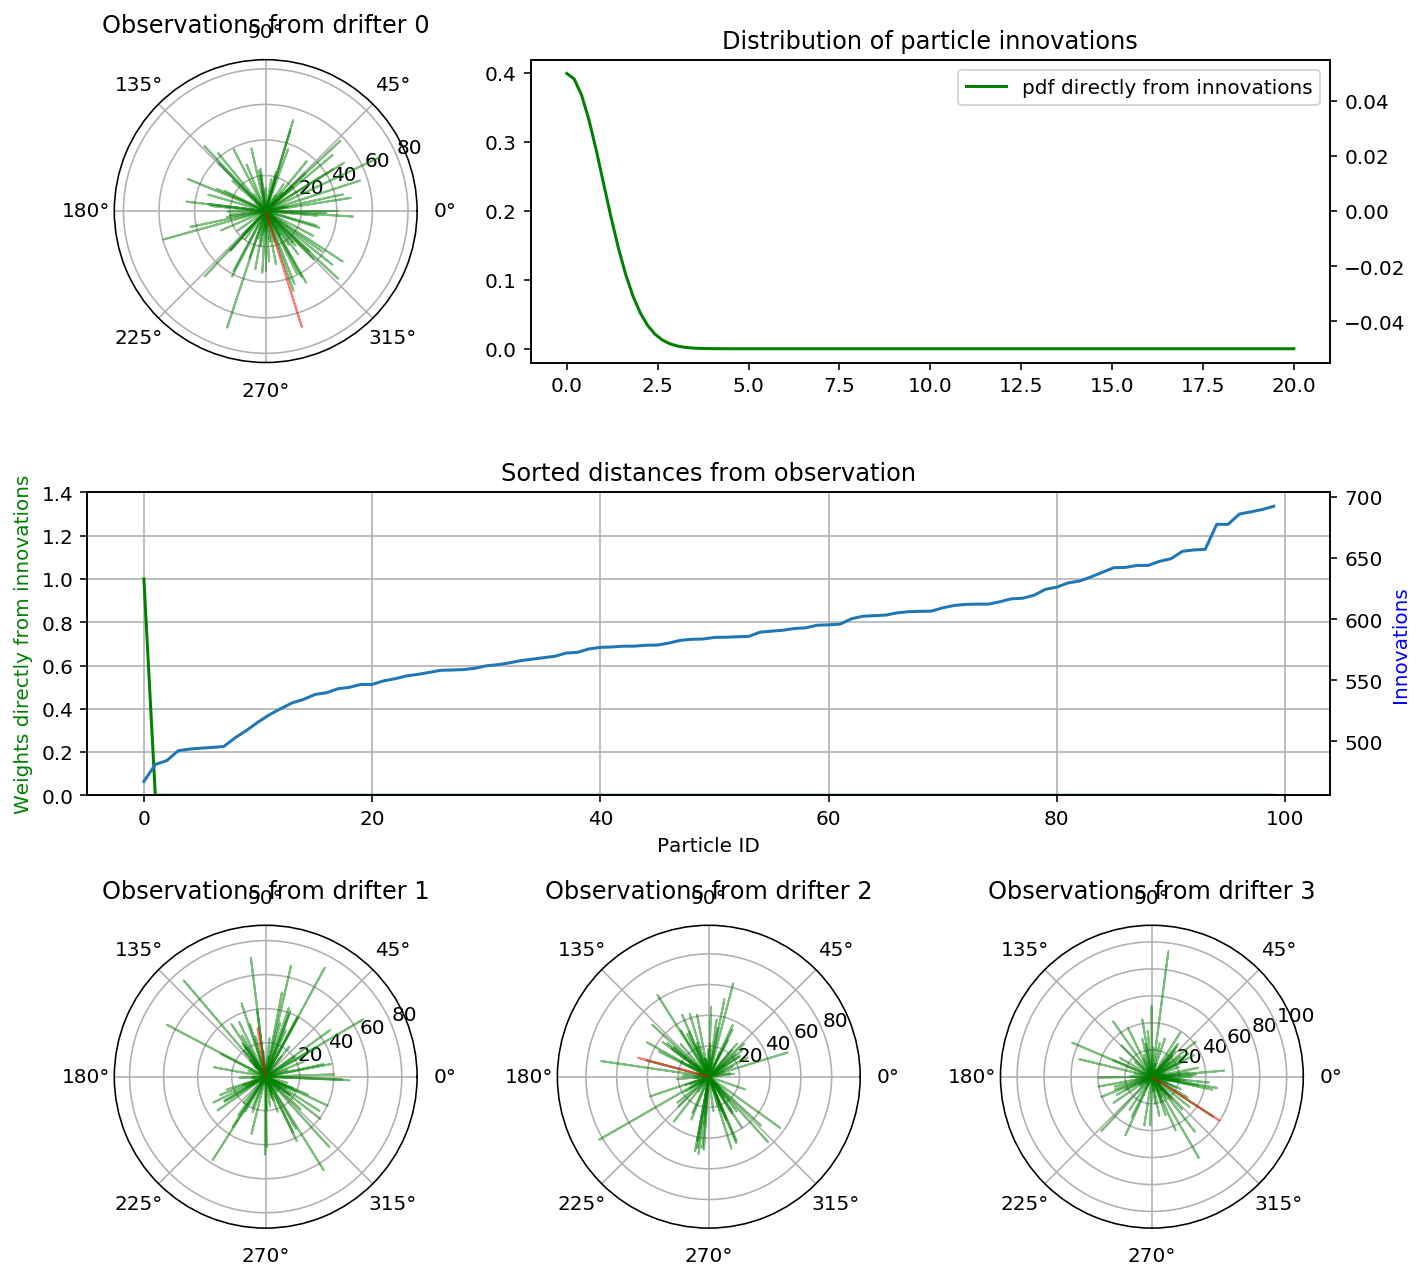

In [10]:
first_obstime_ep = ep.plotDistanceInfo(ensemble)


In [11]:


    
iewpf = IEWPFOcean.IEWPFOcean(ensemble)

numDays = 3
numHours = 24

master_tic = time.time()
for day in range(numDays):
    print('-------- Starting day ' + str(day))

    for hour in range(numHours):

        for fiveMin in range(12):
            
            if (day == 0) and (hour == 0) and (fiveMin == 0):
                iewpf.iewpf_2stage(ensemble, perform_step=False)
                continue
            
            #drifter_cells = ensemble.getDrifterCells()

            for minute in range(5):
                obstime += 60
                ensemble.stepToObservation(obstime, model_error_final_step=(minute<4))

                if minute == 4:
                    iewpf.iewpf_2stage(ensemble, perform_step=False)

                #ensemble.registerStateSample(drifter_cells)
            print('.'+str(fiveMin*5)+'.', end='')
            # Done minutes

        # Done five minutes

        toc = time.time()
        print("\n{:04.1f} s: ".format(toc-master_tic) + " Done simulating hour " + str(hour + 1) + " of day " + str(day + 3))
    # Done hours
# Done day

print('Ready for weight calculation')

-------- Starting day 0


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/scipy/optimize/zeros.py:324: RuntimeWarning: Tolerance of 0.00014999999999998348 reached
  warnings.warn(msg, RuntimeWarning)


.5..10..15..20..25..30..35..40..45..50..55.
45.9 s:  Done simulating hour 1 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
95.2 s:  Done simulating hour 2 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
142.0 s:  Done simulating hour 3 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
189.0 s:  Done simulating hour 4 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
237.0 s:  Done simulating hour 5 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
284.1 s:  Done simulating hour 6 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
330.8 s:  Done simulating hour 7 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
377.6 s:  Done simulating hour 8 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
424.4 s:  Done simulating hour 9 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
471.7 s:  Done simulating hour 10 of day 3
.0..5..10..15..20..25..30..35..40..45..50..55.
518.5 s:  Done simulating hour 11 of day 3
.0..5..10..15..20..25..3

In [12]:
weights_analysis = ensemble.getGaussianWeight(normalize=True, R_scale=1)
weights_analysis.sort()
for i in range(1,11):
    print("{:02.4f}%".format(weights_analysis[-i]*100))
num_above_1_percent = sum(weights_analysis > 0.01)
print("Number of particles with weight > 1%: " + str(num_above_1_percent))
print("Total weight on < 1%: " + str(1-sum(weights_analysis[-num_above_1_percent:])))

100.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
Number of particles with weight > 1%: 1
Total weight on < 1%: 0.0


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


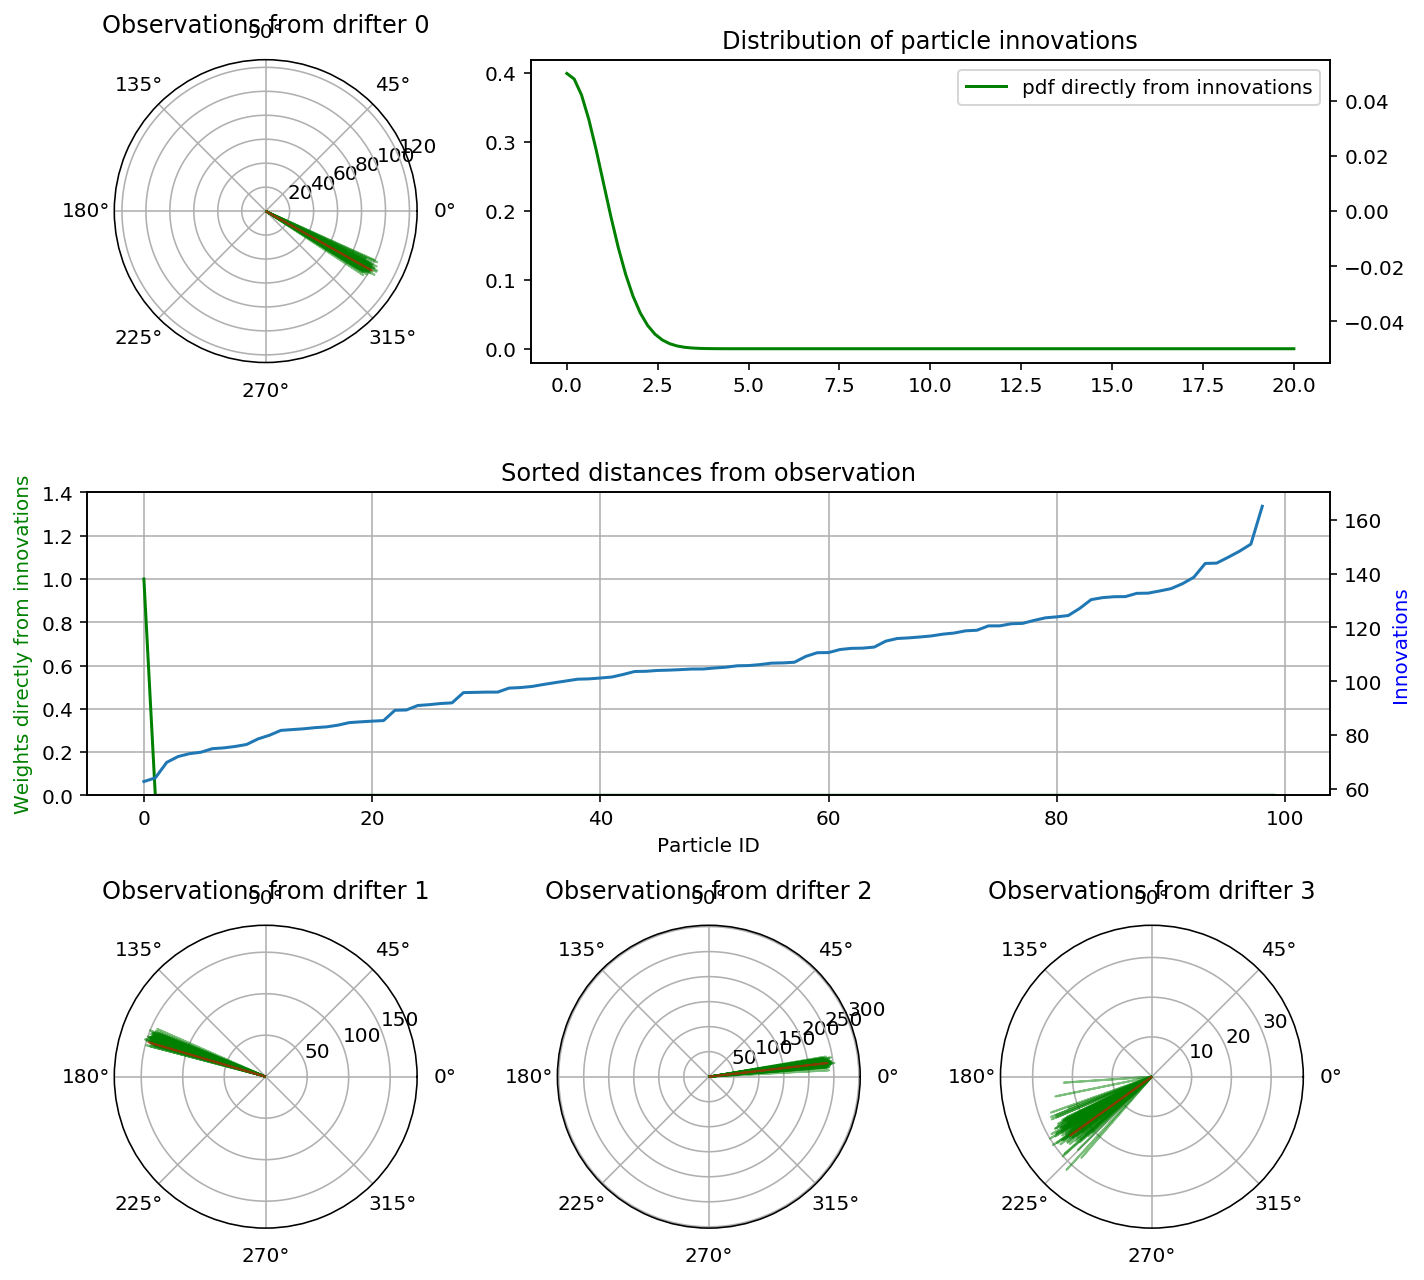

In [13]:
info_analysis = ep.plotDistanceInfo(ensemble)


In [14]:
obstime += 5*60
ensemble.stepToObservation(obstime, model_error_final_step=True)

In [15]:
weights_forecast = ensemble.getGaussianWeight(normalize=True, R_scale=1)
weights_forecast.sort()
for i in range(1,11):
    print("{:02.4f}%".format(weights_forecast[-i]*100) )
num_above_1_percent = sum(weights_forecast > 0.01)
print("Number of particles with weight > 1%: " + str(num_above_1_percent))
print("Total weight on < 1%: " + str(1-sum(weights_forecast[-num_above_1_percent:])))

100.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
0.0000%
Number of particles with weight > 1%: 1
Total weight on < 1%: 0.0


/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/numpy/lib/histograms.py:893: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/home/havahol/miniconda3/envs/gpuocean/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


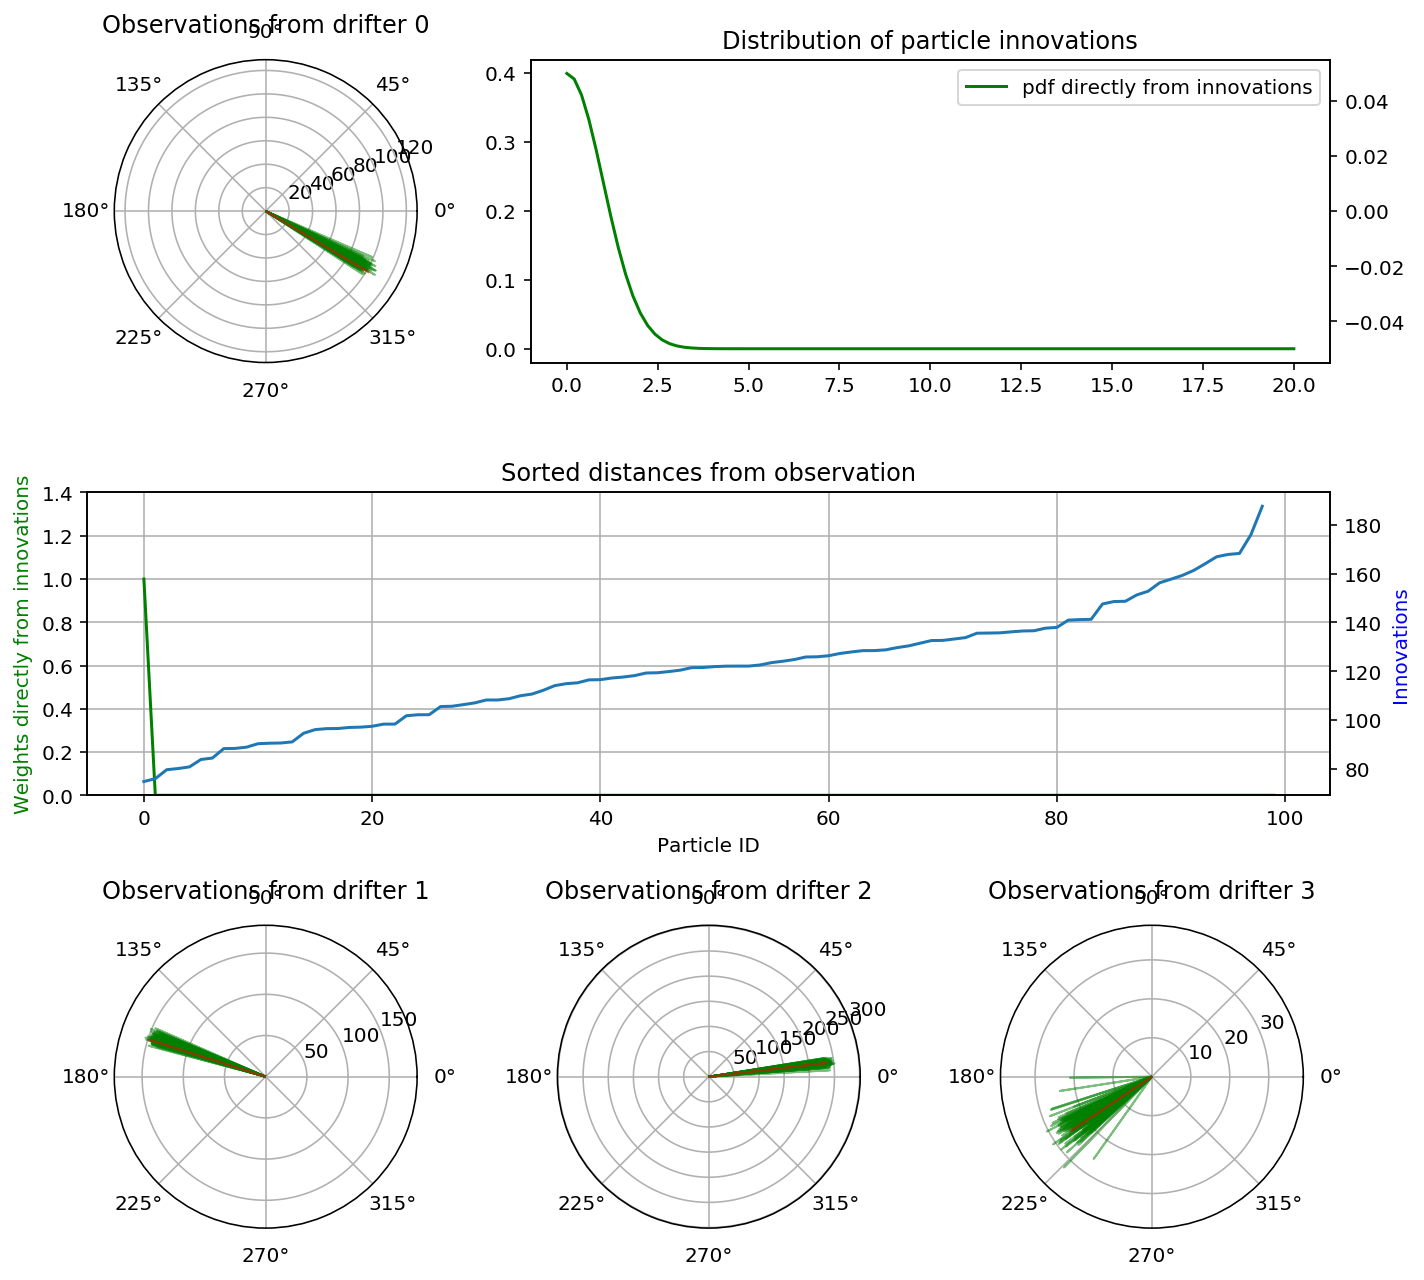

In [16]:
info_forecast = ep.plotDistanceInfo(ensemble)


In [17]:
all_innovations = ensemble.getInnovations()
all_innovations.shape

(100, 64, 2)

In [18]:
drifters = np.arange(64)
selected_drifters = np.random.choice(drifters, size=40, replace=False)
selected_drifters.sort()
selected_drifters

array([ 0,  1,  2,  3,  4,  8,  9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21,
       22, 23, 25, 26, 28, 29, 30, 33, 36, 37, 39, 40, 42, 43, 48, 51, 53,
       54, 55, 56, 57, 59, 63])

In [19]:
float_formatter = lambda x: "%.5f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})


In [20]:
drifterSet = np.arange(64, dtype=np.int32)

mean_particles_above_1_percent = np.zeros(64)
mean_particles_above_1_percent_10R = np.zeros(64)
mean_particles_above_1_percent_50R = np.zeros(64)

for drifter_set_size in range(1,64):

    print("-------- drifterSet length: " + str(drifter_set_size) + " -------")
    
    iterations_per_size = 50
    best_weights = np.zeros((10, iterations_per_size))
    num_above_1_percent     = np.zeros(iterations_per_size, dtype=np.int32)
    num_above_1_percent_10R = np.zeros(iterations_per_size, dtype=np.int32)
    num_above_1_percent_50R = np.zeros(iterations_per_size, dtype=np.int32)
    leftover_weight = np.zeros(iterations_per_size)
    
    for i in range(iterations_per_size):
        selected_drifters = np.random.choice(drifters, size=drifter_set_size, replace=False)
        selected_drifters.sort()
        innovations = all_innovations[:,selected_drifters,:]
    
        weights_forecast     = ensemble.getGaussianWeight(normalize=True, R_scale=1,  \
                                                          innovations=innovations)
        weights_forecast_10R = ensemble.getGaussianWeight(normalize=True, R_scale=10, \
                                                          innovations=innovations)
        weights_forecast_50R = ensemble.getGaussianWeight(normalize=True, R_scale=50, \
                                                          innovations=innovations)
        weights_forecast.sort()
        weights_forecast = weights_forecast[::-1]
        best_weights[:, i] = weights_forecast[:10]
        
        num_above_1_percent[i]     = sum(weights_forecast > 0.01)
        num_above_1_percent_10R[i] = sum(weights_forecast_10R > 0.01)
        num_above_1_percent_50R[i] = sum(weights_forecast_50R > 0.01)
        leftover_weight[i] = 1-sum(weights_forecast[:num_above_1_percent[i]])
    
    mean_particles_above_1_percent[drifter_set_size-1] = num_above_1_percent.mean()
    mean_particles_above_1_percent_10R[drifter_set_size-1] = num_above_1_percent_10R.mean()
    mean_particles_above_1_percent_50R[drifter_set_size-1] = num_above_1_percent_50R.mean()
    
    print(np.array2string(best_weights[:,:8], max_line_width=400))
    print("Number of particles with weight > 1%:\n" + str(num_above_1_percent))
    print("Mean number of particles with weight > 1%: " + str(num_above_1_percent.mean()))
    print("Mean number of particles with weight > 1% with 10R: " + str(num_above_1_percent_10R.mean()))
    print("Mean number of particles with weight > 1% with 50R: " + str(num_above_1_percent_50R.mean()))
    print("Total weight on < 1%:\n" + str(leftover_weight))

-------- drifterSet length: 1 -------
[[0.33925 0.75989 0.07577 0.51429 0.52468 0.32371 0.32014 0.09395]
 [0.26555 0.18121 0.07167 0.25029 0.32712 0.26989 0.28763 0.09289]
 [0.24421 0.02961 0.06585 0.20417 0.06023 0.26705 0.10427 0.08606]
 [0.14171 0.02262 0.06304 0.01381 0.05158 0.09717 0.06317 0.08450]
 [0.00641 0.00470 0.06143 0.00809 0.01956 0.03412 0.05691 0.06329]
 [0.00103 0.00149 0.05840 0.00448 0.00610 0.00288 0.04384 0.06091]
 [0.00079 0.00018 0.05681 0.00291 0.00459 0.00224 0.03891 0.05797]
 [0.00050 0.00011 0.04693 0.00097 0.00377 0.00185 0.01726 0.05071]
 [0.00030 0.00005 0.04668 0.00071 0.00092 0.00081 0.01447 0.04874]
 [0.00012 0.00004 0.04495 0.00011 0.00075 0.00021 0.01446 0.04438]]
Number of particles with weight > 1%:
[ 4  4 24  4  5  5 11 20  3  1 12 24  5  2  3  1 15 10  5  8  2  1 21  2
 13  4  3 18  5 21  5  8 21 12  4 21 11  3 20 11  8  8  3  4  3  2  2  5
 10 15]
Mean number of particles with weight > 1%: 8.64
Mean number of particles with weight > 1% with 10R:

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 0.98404 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.01596 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 2 1 2 1 1 1 3 1 1 1 1 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.16
Mean number of particles with weight > 1% with 10R: 3.0
Mean number of particles with weight > 1% with 50R: 14.2
Total weight on < 1%:
[0.00

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 0.99995]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00005]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.06
Mean number of particles with weight > 1% with 10R: 1.74
Mean number of particles with weight > 1% with 50R: 8.24
Total weight on < 1%:
[0.0

[[0.98181 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000]
 [0.01819 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.04
Mean number of particles with weight > 1% with 10R: 1.54
Mean number of particles with weight > 1% with 50R: 5.28
Total weight on < 1%:
[0.0

[[0.67034 1.00000 1.00000 1.00000 1.00000 1.00000 0.99918 1.00000]
 [0.32966 0.00000 0.00000 0.00000 0.00000 0.00000 0.00082 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 2 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.06
Mean number of particles with weight > 1% with 10R: 1.38
Mean number of particles with weight > 1% with 50R: 3.98
Total weight on < 1%:
[0.0

[[1.00000 1.00000 1.00000 1.00000 0.99808 1.00000 1.00000 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00192 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.02
Mean number of particles with weight > 1% with 10R: 1.46
Mean number of particles with weight > 1% with 50R: 3.28
Total weight on < 1%:
[0.0

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.0
Mean number of particles with weight > 1% with 10R: 1.22
Mean number of particles with weight > 1% with 50R: 2.6
Total weight on < 1%:
[0.000

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 0.93874 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.06126 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 2 1 1 1 1 2 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.06
Mean number of particles with weight > 1% with 10R: 1.3
Mean number of particles with weight > 1% with 50R: 2.4
Total weight on < 1%:
[0.000

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.0
Mean number of particles with weight > 1% with 10R: 1.36
Mean number of particles with weight > 1% with 50R: 2.46
Total weight on < 1%:
[0.00

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.0
Mean number of particles with weight > 1% with 10R: 1.16
Mean number of particles with weight > 1% with 50R: 2.2
Total weight on < 1%:
[0.000

[[1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000 1.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]
 [0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000 0.00000]]
Number of particles with weight > 1%:
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1]
Mean number of particles with weight > 1%: 1.0
Mean number of particles with weight > 1% with 10R: 1.14
Mean number of particles with weight > 1% with 50R: 1.88
Total weight on < 1%:
[0.00

# New results at day 6

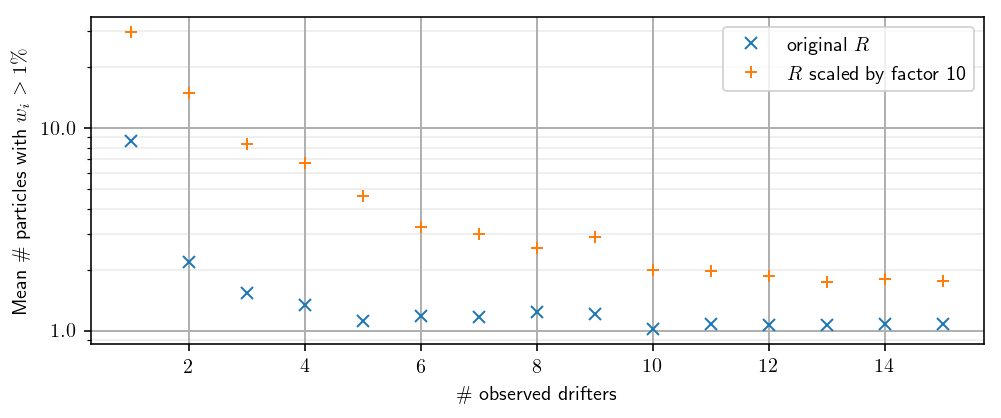

In [42]:
rc('text', usetex=True)

fig = plt.figure(figsize=(8, 3))
ax = fig.add_subplot(1,1,1)

Nd = 15

major_ticks = np.arange(0, Nd, 2)
ax.set_xticks(major_ticks)


ax.semilogy(np.arange(1, Nd+1), mean_particles_above_1_percent[:Nd], 'x', label=r'original $R$')
ax.semilogy(np.arange(1, Nd+1), mean_particles_above_1_percent_10R[:Nd], '+', label=r'$R$ scaled by factor 10')
#ax.semilogy(np.arange(1, Nd+1), mean_particles_above_1_percent_50R[:Nd], '^', label=r'$R$ scaled by factor 50')
#ax.semilogy(np.arange(1, Nd+1), np.ones_like(mean_particles_above_1_percent[:Nd]), ':')
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.grid(which='major', linewidth=1)
ax.grid(which='minor', linewidth=0.2)
ax.legend()
ax.set_ylabel(r'Mean \# particles with $w_i > 1\%$')
ax.set_xlabel(r'\# observed drifters')

folder = '/media/havahol/Seagate Backup Plus Drive/gpu_ocean/june_25_truth/sir/'
timestamp = datetime.datetime.now().strftime("%Y_%m_%d-%H_%M_%S")
filename = folder + 'sir_weight_distribution_' + timestamp 
plt.savefig(filename + '.png', bbox_inches='tight')
plt.savefig(filename + '.pdf', bbox_inches='tight')